## Imports and Files

In [122]:
# Classic Imports 
import pandas as pd
import numpy as np

import math
import time

# Accessing File Imports 
from pathlib import Path

# Plotting Imports 
from matplotlib import pyplot as plt

# Library FFT Imports 
from scipy.fft import fft, fftfreq

# Custom Imports
from wave_generator import create_wave

# All Relevant Variables 
csv_sampling_frequency = 250000
csv_num_data_points = 16384

is_data_from_sampleData1 = False

### Importing from sampleData1

In [123]:
if (is_data_from_sampleData1 == True):

    # CSV Being Analyzed 
    dataFile = "./sampleData1/1.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), header = None)

    hydrophoneData = load_hydrophone_data()

    def addTime(x): 
        return x / csv_sampling_frequency

    hydrophoneData.columns = ['hydrophone1', 'hydrophone2', 'hydrophone3', 'hydrophone4', 'time'] 
    hydrophoneData["time"] = hydrophoneData["time"].apply(addTime)

    sample = np.array(hydrophoneData["hydrophone1"])
    sampling_frequency = 250000

### Importing from sampleData2

In [124]:
if (is_data_from_sampleData1 == False):

    # CSV Being Analyzed 
    dataFile = "./sampleData2/hydros1_and2_close.csv"

    def load_hydrophone_data():
        return pd.read_csv(Path(dataFile), skiprows = 9)
    
    sample = load_hydrophone_data()

    sample = np.array(sample["Channel 2 (V)"])
    sampling_frequency = 160000

## Data Visualizer 

In [125]:
sample                                  # Gives first couple of lines of the csv

array([4.41207419, 4.41273986, 4.41207419, ..., 4.39842808, 4.41240703,
       4.42106066])

## Temporary Manual Bandpass Filter 

In [126]:
print("The original sample is ")
print(sample)
print("\n")

shift = float(np.mean(sample))

print("This is the shift by which all the values are shifted which is " + str(shift))
print("\n")

sample = sample - shift

print("The shifted and modified sample is + ")
print(sample)

The original sample is 
[4.41207419 4.41273986 4.41207419 ... 4.39842808 4.41240703 4.42106066]


This is the shift by which all the values are shifted which is 4.411266329056753


The shifted and modified sample is + 
[ 0.00080787  0.00147353  0.00080787 ... -0.01283825  0.0011407
  0.00979433]


In [127]:
sample = sample * 100

Text(0, 0.5, 'Amplitude')

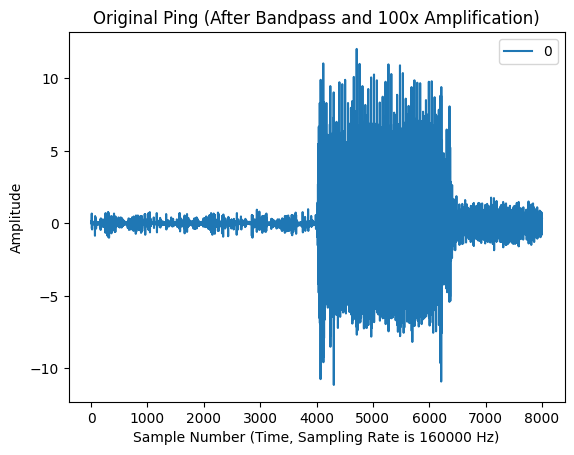

In [147]:
sample1 = sample[0:8000]
sample1 = pd.DataFrame(sample1)

sample1.plot()
plt.title("Original Ping (After Bandpass and 100x Amplification)")
plt.xlabel("Sample Number (Time, Sampling Rate is 160000 Hz)")
plt.ylabel("Amplitude")

## Fourier Transform

In [129]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 200                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 4000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 4200                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

testsample = np.array(sample[startingIndex: endingIndex])

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))

The sampling frequency is 160000
The sample size is 200


Using the scipy library, 200 were analyzed in 0.000125885009765625 seconds.


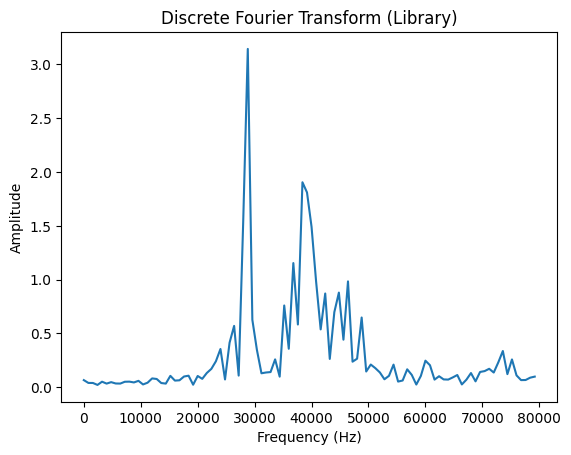

In [130]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(testsample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

## Sliding Fourier Transform for Edge Detection

In [131]:
sampling_frequency                          # Sampling frequency of the hydrophone
N = 128                                     # The size of the shifting window in terms of the number of samples in the window 
startingIndex = 0000                        # This is the index of the first sample to be analyzed in the csv file data which is passed to the fourier analysis
endingIndex = 8000                          # This is the index of the last sample to be analyzed in the csv file data which is passed to the fourier analysis
sample                                      # The data that is to be input into the fourier analysis 

print("The sampling frequency is " + str(sampling_frequency))
print("The sample size is " + str(N))
print("The bucket size from the FFT is " + str(sampling_frequency / N))
print("The higheset frequency captured from the FFT is " + str(sampling_frequency / 2))

The sampling frequency is 160000
The sample size is 128
The bucket size from the FFT is 1250.0
The higheset frequency captured from the FFT is 80000.0


In [132]:
chosenBucketSize = 5000
frequencyToWatch = 35000

sampleNumberArray = []
amplitudeArray = []

for i in range(startingIndex, (endingIndex - N + 1)):

    slidingTestSample = np.array(sample[i: i + N])

    yf = fft(slidingTestSample)
    xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

    frequencies = pd.DataFrame(xf, columns = ["Frequency"])
    amplitudes = pd.DataFrame((2 / N * np.abs(yf[0 : N//2])), columns = ["Amplitude"])

    values = pd.concat([frequencies, amplitudes], axis = 1)

    temp = chosenBucketSize / (sampling_frequency / N)
    index = 0
    newValues = pd.DataFrame(columns = ["Frequency", "Amplitude"])

    currentFrequency = 0
    currentAmplitude = 0

    for j in range(values.shape[0]):
        currentAmplitude = currentAmplitude + values["Amplitude"][j]
    
        if (index == 0):
            currentFrequency = values["Frequency"][j]
        
        index = index + 1

        if (index == temp):
            tempRowDictionary = {"Frequency": currentFrequency, "Amplitude": currentAmplitude}
            tempdf = pd.DataFrame([tempRowDictionary])
            newValues = pd.concat([newValues, tempdf], axis = 0, ignore_index = True)

            currentAmplitude = 0
            index = 0
    

    sampleNumberArray.append(i)
    amplitudeArray.append((newValues.loc[newValues['Frequency'] == frequencyToWatch]).iloc[0, 1])

for i in range(len(sampleNumberArray)):
    print(str(sampleNumberArray[i]) + "\t\t" + str(amplitudeArray[i]))

0		0.10862325874202185
1		0.1086844704906436
2		0.11112632324196371
3		0.11281005894738973
4		0.1153584868444236
5		0.11360289462227069
6		0.11475010343045441
7		0.11600274082294701
8		0.11779173550670431
9		0.1146822054580785
10		0.11584317597975965
11		0.11760259892275617
12		0.11752345567243037
13		0.08427928800688922
14		0.08562599812537947
15		0.07151556803796463
16		0.06428327745121515
17		0.06223492488820169
18		0.06313731401748589
19		0.061330064908611856
20		0.05510267958198668
21		0.05381838888658204
22		0.05357151356318672
23		0.05321109927395487
24		0.053376776846652665
25		0.053376776846652665
26		0.05444363278214712
27		0.054321433015747725
28		0.054797757462263195
29		0.05544542736789383
30		0.05544542736789495
31		0.05857137331383129
32		0.05861817206485336
33		0.05930022197330839
34		0.0619445537666585
35		0.05870663185041155
36		0.05408917160315245
37		0.05358534255281672
38		0.05259350001458786
39		0.05400117842451031
40		0.05642023356067555
41		0.057175342838920354


Text(0, 0.5, 'Amplitude')

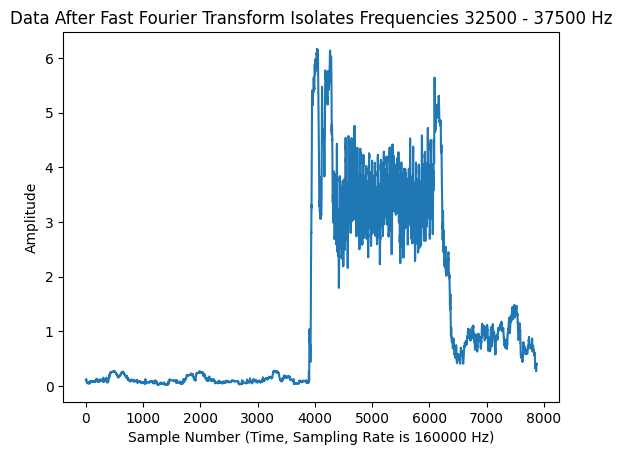

In [149]:
plt.plot(sampleNumberArray, amplitudeArray)
plt.title("Data After Fast Fourier Transform Isolates Frequencies 32500 - 37500 Hz")
plt.xlabel("Sample Number (Time, Sampling Rate is 160000 Hz)")
plt.ylabel("Amplitude")

Using the scipy library, 128 were analyzed in 0.000102996826171875 seconds.


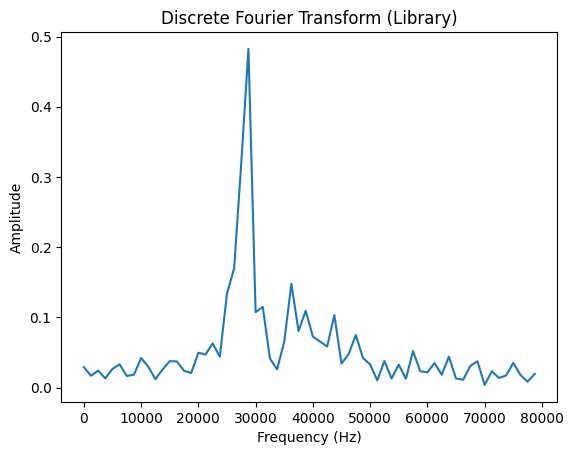

In [134]:
# DISCRETE FOURIER ANALYSIS USING SCIPY LIBRARY
# ----------------------------------------------

# For measuring execution time. 
start = time.time()

# Number of samples in normalized_tone
yf = fft(slidingTestSample)
xf = fftfreq(N, 1 / sampling_frequency)[:(N // 2)]

end = time.time()
print("Using the scipy library, " + str(N) + " were analyzed in " + str(end - start) + " seconds.")

plt.plot(xf, 2 / N * np.abs(yf[0 : N//2]))        # Ignore this error 

plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Discrete Fourier Transform (Library)")
plt.show()

In [135]:
pd.DataFrame(xf)
pd.DataFrame()

""


## Data Viewed in Detail

### Original Data

Text(0, 0.5, 'Amplitude')

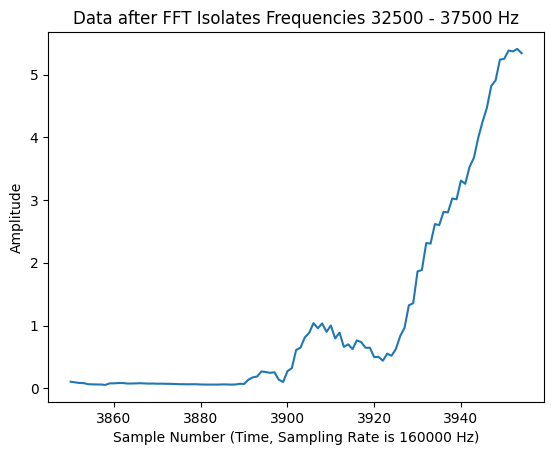

In [157]:
plt.plot(sampleNumberArray[3850:3975], amplitudeArray[3850:3975])
plt.title("Data after FFT Isolates Frequencies 32500 - 37500 Hz")
plt.xlabel("Sample Number (Time, Sampling Rate is 160000 Hz)")
plt.ylabel("Amplitude")

### DFT Data

<AxesSubplot: >

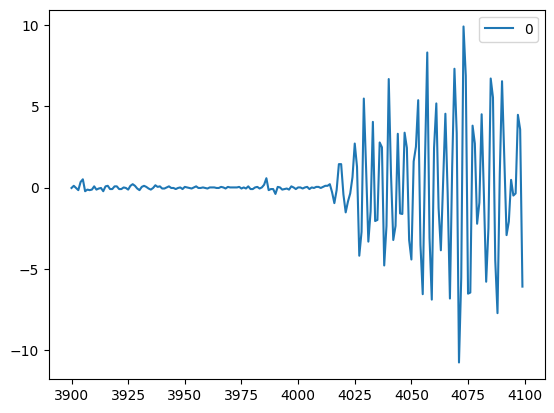

In [152]:
sample1[3900:4100].plot()

## Edge Detection

In [138]:
amplitudeArray[0:2500]

[0.10862325874202185,
 0.1086844704906436,
 0.11112632324196371,
 0.11281005894738973,
 0.1153584868444236,
 0.11360289462227069,
 0.11475010343045441,
 0.11600274082294701,
 0.11779173550670431,
 0.1146822054580785,
 0.11584317597975965,
 0.11760259892275617,
 0.11752345567243037,
 0.08427928800688922,
 0.08562599812537947,
 0.07151556803796463,
 0.06428327745121515,
 0.06223492488820169,
 0.06313731401748589,
 0.061330064908611856,
 0.05510267958198668,
 0.05381838888658204,
 0.05357151356318672,
 0.05321109927395487,
 0.053376776846652665,
 0.053376776846652665,
 0.05444363278214712,
 0.054321433015747725,
 0.054797757462263195,
 0.05544542736789383,
 0.05544542736789495,
 0.05857137331383129,
 0.05861817206485336,
 0.05930022197330839,
 0.0619445537666585,
 0.05870663185041155,
 0.05408917160315245,
 0.05358534255281672,
 0.05259350001458786,
 0.05400117842451031,
 0.05642023356067555,
 0.057175342838920354,
 0.05598540292204601,
 0.04566060914288304,
 0.05231891118057113,
 0.04735

In [139]:
threshold = np.mean(amplitudeArray[0:2500])
threshold = np.percentile(amplitudeArray[0:2500], 90)
threshold = threshold * 2
print(threshold)

0.4664406910889823


In [140]:
flag = False
edgeStart = 0

for i in range(0, len(amplitudeArray)):
    if (flag == False):
        if (amplitudeArray[i] > threshold):
            edgeStart = i
            flag = True

print("The start of the edge is " + str(edgeStart))

The start of the edge is 3902
